<a href="https://colab.research.google.com/github/amandaventurac/PhD_salaries/blob/main/PhD_salaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/amandaventurac/PhD_salaries/main/phd_stipend.csv"
df1 = pd.read_csv(url)
print("This dataset has {} rows and {} columns".format(df1.shape[0], df1.shape[1]))
display(df1.head())
display(df1.dtypes.value_counts)

This dataset has 9201 rows and 11 columns


,University,Department,Overall Pay,LW Ratio,Academic Year,Program Year,12 M Gross Pay,9 M Gross Pay,3 M Gross Pay,Fees,Comments
0,Mount Sinai School of Medicine,MD/PhD,"$34,000",1.14,2016-2017,3rd,"$34,000",NaN,NaN,NaN,NaN
1,University of California - Irvine (UCI),Cognitive Sciences,"$27,000",0.92,2020-2021,4th,"$27,000",NaN,NaN,NaN,Insurance and tuition are covered
2,University of California - Santa Barbara (UCSB),ECE,"$35,000",1.33,2020-2021,2nd,"$35,000",NaN,NaN,NaN,NaN
3,George Washington University (GW),Immunology,"$33,000",1.07,2021-2022,1st,"$33,000",NaN,NaN,NaN,NaN
4,University of Oregon (UO),Counseling Psychology,"$23,200",1.11,2020-2021,4th,"$23,200",NaN,NaN,NaN,Pay is on a set schedule based on advancement ...


<bound method IndexOpsMixin.value_counts of University         object
Department         object
Overall Pay        object
LW Ratio          float64
Academic Year      object
Program Year       object
12 M Gross Pay     object
9 M Gross Pay      object
3 M Gross Pay      object
Fees               object
Comments           object
dtype: object>

The dataset was sucessfully imported. It seems that the column names were properly imported. The only numerical column at this moment is "LW Ratio". Therefore, '.describe()' method would only describe the LW column. In this case, it's better to clean and to convert the data before using '.describe()'.  Before beginning with data manipulation, I will check if I can access the data using the data column, and the data line index.


In [2]:
df1['University'][0]

'Mount Sinai School of Medicine'

In [3]:
df1['Department'][1]

'Cognitive Sciences'

It looks correct, I can already access the data using column name and line index. It has 9200 lines and 11 columns, it is not so big. Okay, the computational processing cost will be small. After a quick look at the columns, we can see that:
- Only LW ratio is int type, I should convert  Overall Pay to int type.
-The frequency of payment can be ignored if the 'NaN' pattern in 9 months and 3 months columns is repeated for most of columns. 
- Maybe I can work with Overall pay column solely to represent the payment, instead of 12 months, 9 months and 3 months Gross Pay. 
-I can convert the program year to a numerical type, it make sense if I construct a model that takes into account this indicator. 
 
I will check how many entries are 'NaN'or null on 3 months and 9 months Gross pay columns. I will delete these columns if there are many missing values. 

In [4]:
df1["9 M Gross Pay"].isnull().sum()

6612

6612 missing 9 months gross pay values on 9201 rows ... huge amount of missing data. Let me check the 3 months gross pay missing values:

In [5]:
df1["3 M Gross Pay"].isnull().sum()

8364

Even worst than previous result. I will definitely delete these columns, they are useless. Overall payment is the financial information that I need in this case. I will also drop the comments column.

In [6]:
df1.drop(labels = ["9 M Gross Pay", "3 M Gross Pay", "12 M Gross Pay", "Comments"], axis = 1, inplace = True)
df1.head()

,University,Department,Overall Pay,LW Ratio,Academic Year,Program Year,Fees
0,Mount Sinai School of Medicine,MD/PhD,"$34,000",1.14,2016-2017,3rd,NaN
1,University of California - Irvine (UCI),Cognitive Sciences,"$27,000",0.92,2020-2021,4th,NaN
2,University of California - Santa Barbara (UCSB),ECE,"$35,000",1.33,2020-2021,2nd,NaN
3,George Washington University (GW),Immunology,"$33,000",1.07,2021-2022,1st,NaN
4,University of Oregon (UO),Counseling Psychology,"$23,200",1.11,2020-2021,4th,NaN


Now let me check how many missing values we have in Overall Pay column:

In [7]:
df1["Overall Pay"].isnull().sum()

29

29 missing values in 9201 rows = 0.3%. Let me take a look at these entries: 

In [8]:
vector_of_pay_null_entries = df1["Overall Pay"].isnull()
display(df1[:][vector_of_pay_null_entries])

,University,Department,Overall Pay,LW Ratio,Academic Year,Program Year,Fees
107,George Washington University (GW),International Relations and Affairs,NaN,0.0,2020-2021,3rd,"$40,000"
108,George Washington University (GW),International Relations and Affairs,NaN,0.0,2020-2021,3rd,"$40,000"
211,Texas Woman&#39;s University,9,NaN,NaN,2022-2023,3rd,$9
257,University College London,Economics,NaN,NaN,2020-2021,4th,NaN
265,University of California - Los Angeles (UCLA),Geology,NaN,0.0,2020-2021,1st,"$1,000"
266,University of California - Los Angeles (UCLA),Geology,NaN,0.0,2020-2021,1st,"$1,000"
271,California Institute of Technology (Caltech),chemistry,NaN,0.0,2020-2021,4th,"$2,200"
407,Missouri University of Science &amp; Technology,Materials science and engineering,NaN,NaN,2020-2021,1st,"$1,500"
2289,University of Washington (UW),Health Services Research,NaN,0.0,2018-2019,NaN,NaN
2350,University of Dayton (UD),Chemical Engineering,NaN,0.0,2019-2020,1st,NaN


There are some complete null entries, could I trust the information that comes from a row with null university value? It makes more sense to drop these values at all. I will not do any categorical data imputation through the university mode, a row without the university name on PhD stipend dataset may be a little suspicious...  

In [9]:
vector_of_university_null_entries = df1["University"].isnull()
display(df1[:][vector_of_university_null_entries])
df1 = df1.drop(df1.index[vector_of_university_null_entries], axis=0)

,University,Department,Overall Pay,LW Ratio,Academic Year,Program Year,Fees
25,NaN,economics,"$30,000",NaN,2021-2022,NaN,NaN
26,NaN,economics,"$25,000",NaN,2020-2021,NaN,NaN
47,NaN,NaN,"$35,000",NaN,2020-2021,NaN,NaN
78,NaN,Entomology,"$22,868",NaN,2020-2021,4th,$132
87,NaN,mechanical Engg,"$16,000",NaN,2020-2021,2nd,"$2,000"
...,...,...,...,...,...,...,...
8842,NaN,NaN,"$28,000",NaN,2014-2015,4th,NaN
8856,NaN,NaN,"$29,420",NaN,2014-2015,NaN,NaN
8883,NaN,NaN,"$-11,800",NaN,2014-2015,NaN,"$14,000"
8904,NaN,NaN,"$20,500",NaN,2014-2015,2nd,"$1,500"


Now that we cleaned this dataset based on null University entries, the next question about data cleaning is: when "NaN" is important and should be considered on onther columns?
We see that some columns may have  a not null value on Fee column and a NaN value on Overall Pay. 
This information is important, it represents the number os PhD students that declare paying a Fee and did not declare receiving a Payment. 
Lets check if they are many students or not. And we will see some strange data:

In [10]:
dont_receive_payment_vector = df1["Overall Pay"].isnull()
dont_receive_payment = df1[:][dont_receive_payment_vector]
pay_fee_dont_receive_payment = dont_receive_payment.drop(dont_receive_payment.index[dont_receive_payment["Fees"].isnull()], axis = 0)
display(pay_fee_dont_receive_payment)

,University,Department,Overall Pay,LW Ratio,Academic Year,Program Year,Fees
107,George Washington University (GW),International Relations and Affairs,NaN,0.0,2020-2021,3rd,"$40,000"
108,George Washington University (GW),International Relations and Affairs,NaN,0.0,2020-2021,3rd,"$40,000"
211,Texas Woman&#39;s University,9,NaN,NaN,2022-2023,3rd,$9
265,University of California - Los Angeles (UCLA),Geology,NaN,0.0,2020-2021,1st,"$1,000"
266,University of California - Los Angeles (UCLA),Geology,NaN,0.0,2020-2021,1st,"$1,000"
271,California Institute of Technology (Caltech),chemistry,NaN,0.0,2020-2021,4th,"$2,200"
407,Missouri University of Science &amp; Technology,Materials science and engineering,NaN,NaN,2020-2021,1st,"$1,500"
4328,Virginia Tech,education,NaN,0.0,2019-2020,5th,"$76,666"
4487,CUNY - John Jay College,Political Science,NaN,0.0,2018-2019,6th and up,"$35,000"
4610,Cornell University (CU),botany,NaN,0.0,2018-2019,1st,$1


9 dollars  and 1 dollar of Fees? I will not take it into account, that's really cheap. Let's drop it of and count how many students declare paying real Fees without receiving any Payment:

In [11]:
import numpy as np
low_fees_vector = []
low_fees_entries = ["$1", "$9"]
for element in low_fees_entries:
  i = np.where(pay_fee_dont_receive_payment["Fees"] == element)[0].sum() #sum to transform an array into number
  low_fees_vector.append(i)
print(low_fees_vector)


[9, 2]


In [12]:
pay_fee_dont_receive_payment.drop(pay_fee_dont_receive_payment.index[low_fees_vector], axis = 0, inplace = True)
print("{} students declared to pay Fees without receiving any Payment".format(pay_fee_dont_receive_payment.shape[0]))

14 students declared to pay Fees without receiving any Payment


Only 14 students reported paying fees without receiving any payment in 9201 respondents. Now that we cleaned the dataset excluding the suspicious entries, we can consider this simple question: how many students do not receive any payment? 

In [13]:
students_without_payment = df1["Overall Pay"].isnull()
sum_students_without_payment = students_without_payment.sum()

In [14]:
print("{} students declared not to receive any Payment".format(sum_students_without_payment))

24 students declared not to receive any Payment


24 students do not receive payment in 9201 respondents. We can see that the PhD position is remunerated in almost all cases. The other questions that arise form this conclusion are:


*   How is the PhD students salary distributed in USA? (Median, variability, outliers)
*   Is there a relation between the mean salary and the University location?
*   Is there a relation between the mean salary and the Department?
*   Is there a relation between the mean salary and the Program year? What can also be posed as: does the program tradition play a role on PhD salaries?
*   Could we predict the salary of a PhD student depending on these three factors?
*   Is there a relation between the LW (Living Wage ratio of salary) and the University location?
*   If yes, which are the states where the LW of PhD salaries are the higher? And wich are the states where this ratio is lower? 

To answer these question, it is necessary to perform some **data pre-processing** 

*   Drop all the rows where the overall pay do not exists. 
*   Drop the rows with non-USA universities
*   Correlate the univerties to states
*   Group the the departments by field of knowledge

The data types should be converted to:

University: categorical, grouped by the name of University

Department: categorical and grouped by knowledge fields.

Program year: integer

Academic year: integer of the beggining year.

As the payment is the analysis target, it is necessery to drop all the rows where the overall pay do not exists. 

In [15]:
df2 = df1.drop(df1.index[students_without_payment], axis = 0)

Other imporant thing to do it's to treat the "University" column, removing the non-usa entries.

**Treating the 'University' Column:**

The US has 1130 universities indexed on https://www.whatwilltheylearn.com/schools/compare in 2021 January.

We expect that the unique values on 'University' column is less or equal than 1130. If it is more than this quantity, we probably have mistyping errors. Let's check it:

In [16]:
unique_university_entries_as_received = set(df2['University'])
quantity_unique_university_entries_as_received = len(set(df2['University']))
print("There are {} unique university entries in the received data set.".format(quantity_unique_university_entries_as_received))

There are 713 unique university entries in the received data set.


This is coherent value. But let's look at these entries. You can visualize the entryes vertically if you delete the '#' below. We can see that there are Universities out of USA, as Leipzig, ETH Zurich and so on. This data is unwanted. As most of data is from USA Universities in this dataset, the statistical study should comprise only the USA. Data from the other countries are minority and thus cannot represent the reality in these other countries.    

In [17]:
#for element in unique_university_entries_as_received:
  #print(element)
print(unique_university_entries_as_received)

{'Kent State University (KSU)', 'University of Notre Dame (ND)', 'Ohio University', 'National Technical University of Athens', 'Bilkent University', 'University of Northern Colorado (UNC)', 'University of Oregon', 'Rutgers University', 'SUNY Polytechnic Institute', 'McGill', 'Albany Medical College', 'University of Birmingham ', 'University of Southern Mississippi (USM)', 'University of California - Santa Cruz', 'University of Southern California (USC)', 'KU Leuven', 'Stony Brook University', 'The university of Hong Kong', 'University of Brighton ', 'University of Toronto ', 'University of Sussex ', 'University of Sciences ', 'University of Texas - San Antonio (UTSA)', 'University of South Carolina (USC)', 'Brandeis University', 'Temple University', 'American University (AU)', 'University of Manitoba', 'CUNY Graduate School and University Center', 'Wichita State University (WSU)', 'University of Oklahoma (OU)', 'University of Wyoming (UW)', 'Missouri University of Science &amp; Technol

 We can see that there are different entries for the same university,  with and without the initials inside parenthesis. To avoid this, I will create a new list with the same lenght of df2["University"] column, composed by the entries splitted before "(". I can also remove the unnecesarry blank spaces and convert the strings to lower case. Then, I will check if this list has fewer unique values.

In [18]:
list_university_without_initials = []
for element in df2["University"]:
  before_initials = element.split("(")[0]
  before_initials = before_initials.strip()
  before_initials = before_initials.lower()
  list_university_without_initials.append(before_initials)
unique_university_entries_after_processing = list(set(list_university_without_initials))
print("There is {} unique university entries after preliminar processing".format( len(unique_university_entries_after_processing)))
#for element in unique_university_entries_after_processing:
  #print(element)


There is 629 unique university entries after preliminar processing


After reducing the entries quantity, it is usefull to remove the non-USA universities. At wikipedia we can find a list of US universities per State in html format: https://en.wikipedia.org/wiki/List_of_state_and_territorial_universities_in_the_United_States. We should also take into account the Technology institutes, list avalilable on https://en.wikipedia.org/wiki/List_of_United_States_technological_universities.
After a small process, the list of universities and states can be generated.
It is usefull to create a dictionary that links the university name and the State, then we can construct a state column based on the university column.

In [19]:
from google.colab import files
uploaded = files.upload()

Saving list_of_usa_university_state3.txt to list_of_usa_university_state3.txt


In [20]:
text_file_universities_path ='list_of_usa_university_state3.txt'
university_keys = []
state_values = []
text_file_universities = open(text_file_universities_path, "r")
for line in text_file_universities:
  university_keys.append(line.split("/")[0])
  state_values.append((line.split("/")[1]).split("\n")[0])
dict_universities_states = dict(zip(university_keys,state_values))
print(dict_universities_states)

{'tuskegee university': 'alabama', 'alabama a&m university': 'alabama', 'alabama state university': 'alabama', 'athens state university': 'alabama', 'auburn university system': 'alabama', 'auburn university': 'alabama', 'auburn university at montgomery': 'alabama', 'jacksonville state university': 'alabama', 'troy university': 'alabama', 'university of alabama system': 'alabama', 'university of alabama': 'alabama', 'university of alabama at birmingham': 'alabama', 'university of alabama in huntsville': 'alabama', 'university of montevallo': 'alabama', 'university of north alabama': 'alabama', 'university of south alabama': 'alabama', 'university of west alabama': 'alabama', 'university of alaska system': 'alaska', 'university of alaska fairbanks': 'alaska', 'university of alaska anchorage': 'alaska', 'university of alaska southeast': 'alaska', 'grand canyon university': 'arizona', 'university of arizona college of medicine-phoenix': 'arizona', 'northcentral university': 'arizona', 'ari

Now it's time to design a test function to identify mistyping errors and non-USA universities. We can check which entries are very similar. Python has a 'Sequence Matcher' package, that allows indentifying the similarity between two strings.

**Mistyping University detection test**

Step 1: define a similarity criterion between 0 and 1: 

    let's begin with defined_criterion: 0.9:


Step 2 : run the pseudocode below:

    for each entry on list_university_without_initials: 

        compare this df2 entry with the USA universities list using a SequenceMatcher function
        if there is a similarity between (df2 entry and an element on USA universities list) above the defined_criterion: 
            the df2 entry is related to the USA university with higher similarity through the dictionary dict2

Step 3: **check if the university values on dataframe were well correlated with an existing USA university list element.** 

    if the defined_criterion did not correct possible mistyping :

          decrease the defined_criterion and come back to step2

    decrease the criterion until mistyping hypothesis verification.
    observe that the defined_criterion should be optimized to perform good correlations and avoid bad correlations.

In [21]:
from difflib import SequenceMatcher

def similar(a, i, similarity):
    similarity += SequenceMatcher(None, a, i).ratio()
    return similarity

In [22]:
list_dict_universities = list(dict_universities_states.keys())
defined_criterion = 0.9
values_dict2 = []
keys_dict2 = []
for i in range(0, len(unique_university_entries_after_processing)):
  list_similarities = []
  list_keys = []
  for a in range (0, len(list_dict_universities)):
    similarity = 0
    similarity = similar(unique_university_entries_after_processing[i],list_dict_universities[a], similarity)
    if similarity >= 0.8:
      list_similarities.append(similarity)
      list_keys.append(list_dict_universities[a])
    else:
      list_similarities.append(0)
      list_keys.append(0)
  max_similarity = np.max(list_similarities)
  max_similarity_index = list_similarities.index(max_similarity)
  value = list_keys[max_similarity_index]
  key = unique_university_entries_after_processing[i]
  values_dict2.append(value)
  keys_dict2.append(key)
dict2 = dict(zip(keys_dict2,values_dict2))
print(dict2)

{'northern arizona university': 'northern arizona university', 'university of tennessee health science center': 'university of tennessee health science center', 'george mason university': 'george mason university', 'oakland university': 'oakland university', 'george washington university': 'george washington university', 'university of colorado - denver': 'university of colorado denver', 'uf': 0, 'university of cincinnati': 'university of cincinnati', 'university of auckland': 'university of akron', 'university of alabama': 'university of alabama', 'australian national university': 0, 'james cook university': 'james madison university', 'marquette university': 'marquette university', 'kansas state university': 'kansas state university', 'national institutes of health': 'national institutes of health', 'duke-nus, singapore': 0, 'walden university': 'walden university', 'brandeis university': 'brandeis universit', 'university college london': 0, 'clark atlanta university': 'clark atlanta

With the defined criterion of 0.9, almost all correlation were done correctly. The non-USA exceptions miscorrelated to USA universities were added to an "exclusion list". The algorithm was modified to detect if the university is in this black list or not.

In [23]:
from google.colab import files
uploaded = files.upload()

Saving non_usa to non_usa


In [24]:
non_usa_path ='non_usa'
list_non_usa = []
non_usa_file = open(non_usa_path, "r")
for line in non_usa_file:
  data = line.split("\n")[0]
  data = data.strip()
  data = data.lower()
  list_non_usa.append(data)
print(list_non_usa)

['university of amsterdam', 'university of guelph', 'university of oslo', 'kth royal institute of technology', 'university of twente', 'university of mumbai', 'university of sussex', 'university of zurich', 'university of bar', 'sofia university', 'sofia university', 'university of bristol', 'university of brighton', 'massey university', 'university of regina', 'university of padua', 'university of antwerp', 'university of calgary', 'university of sciences', 'university of greifswald', 'university of cambridge', 'test university', 'anna university', 'university of queensland', 'university of auckland', 'university of guelp', 'mcgill university', 'university of victoria', 'university of turku', 'university of waterloo', 'university of tuebingen', 'norwegian university of science and technology', 'university of tokyo', 'university of alberta', 'university of western ontario', 'university of gothenburg', 'uppsala university', 'cranfield university', 'university of edinburgh', 'university 

In [25]:
list_dict_universities = list(dict_universities_states.keys())
defined_criterion = 0.9
values_dict2 = []
keys_dict2 = []
for i in range(0, len(unique_university_entries_after_processing)):
  list_similarities = []
  list_keys = []
  for a in range (0, len(list_dict_universities)):
    similarity = 0
    similarity = similar(unique_university_entries_after_processing[i],list_dict_universities[a], similarity)
    if similarity >= 0.8 and unique_university_entries_after_processing[i] not in list_non_usa:
      list_similarities.append(similarity)
      list_keys.append(list_dict_universities[a])
    else:
      list_similarities.append(0)
      list_keys.append(0)
  max_similarity = np.max(list_similarities)
  max_similarity_index = list_similarities.index(max_similarity)
  value = list_keys[max_similarity_index]
  key = unique_university_entries_after_processing[i]
  values_dict2.append(value)
  keys_dict2.append(key)
dict2 = dict(zip(keys_dict2,values_dict2))
print(dict2)

{'northern arizona university': 'northern arizona university', 'university of tennessee health science center': 'university of tennessee health science center', 'george mason university': 'george mason university', 'oakland university': 'oakland university', 'george washington university': 'george washington university', 'university of colorado - denver': 'university of colorado denver', 'uf': 0, 'university of cincinnati': 'university of cincinnati', 'university of auckland': 0, 'university of alabama': 'university of alabama', 'australian national university': 0, 'james cook university': 0, 'marquette university': 'marquette university', 'kansas state university': 'kansas state university', 'national institutes of health': 'national institutes of health', 'duke-nus, singapore': 0, 'walden university': 'walden university', 'brandeis university': 'brandeis universit', 'university college london': 0, 'clark atlanta university': 'clark atlanta university', 'boise state university': 'bois

Now that the universities are well matched, it is useful to add 2 columns on dataset: 

*   'university_cleaned_column': with the correct university , constructed with dict2 association.
*   'state_cleaned_column': associated state to university_cleaned value through the dict_universities.

In [26]:
university_cleaned = []
state_cleaned = []
for i in range (0, len(list_university_without_initials)):
  this_university = dict2.get(list_university_without_initials[i])
  try:
    this_state = dict_universities_states.get(this_university)
  except:
    this_state = 0
  university_cleaned.append(this_university)
  state_cleaned.append(this_state)
df2 = df2.assign(university_cleaned_column = university_cleaned)
df2 = df2.assign(state_cleaned_column = state_cleaned)
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", 20)
print(df2)

                                           University              Department  \
0                      Mount Sinai School of Medicine                  MD/PhD   
1             University of California - Irvine (UCI)      Cognitive Sciences   
2     University of California - Santa Barbara (UCSB)                     ECE   
3                   George Washington University (GW)              Immunology   
4                           University of Oregon (UO)  Counseling Psychology    
...                                               ...                     ...   
9196                             Duke University (DU)            Biochemistry   
9197                     University of Virginia (UVA)    Chemical Engineering   
9198                             Duke University (DU)  Biomedical Engineering   
9199                     University of Virginia (UVA)    Chemical Engineering   
9200                             Duke University (DU)  Biomedical Engineering   

     Overall Pay  LW Ratio 

The non-USA universities can be identified as the null values on state_cleaned_columns. It's time to drop them out. 

In [69]:
vector_non_usa = df2["state_cleaned_column"].isnull()
df3 = df2.drop(df2.index[vector_non_usa], axis = 0)
print(df3)

                                           University              Department  \
0                      Mount Sinai School of Medicine                  MD/PhD   
1             University of California - Irvine (UCI)      Cognitive Sciences   
2     University of California - Santa Barbara (UCSB)                     ECE   
3                   George Washington University (GW)              Immunology   
4                           University of Oregon (UO)  Counseling Psychology    
...                                               ...                     ...   
9196                             Duke University (DU)            Biochemistry   
9197                     University of Virginia (UVA)    Chemical Engineering   
9198                             Duke University (DU)  Biomedical Engineering   
9199                     University of Virginia (UVA)    Chemical Engineering   
9200                             Duke University (DU)  Biomedical Engineering   

     Overall Pay  LW Ratio 

Before going on, it can be useful to look at the occurrence count on the state column to check if all states are in the US. **We can see that Puerto Rico and Hawaii are listed, but as this analysis is focused on the US, it is necessary to drop these entries out.**

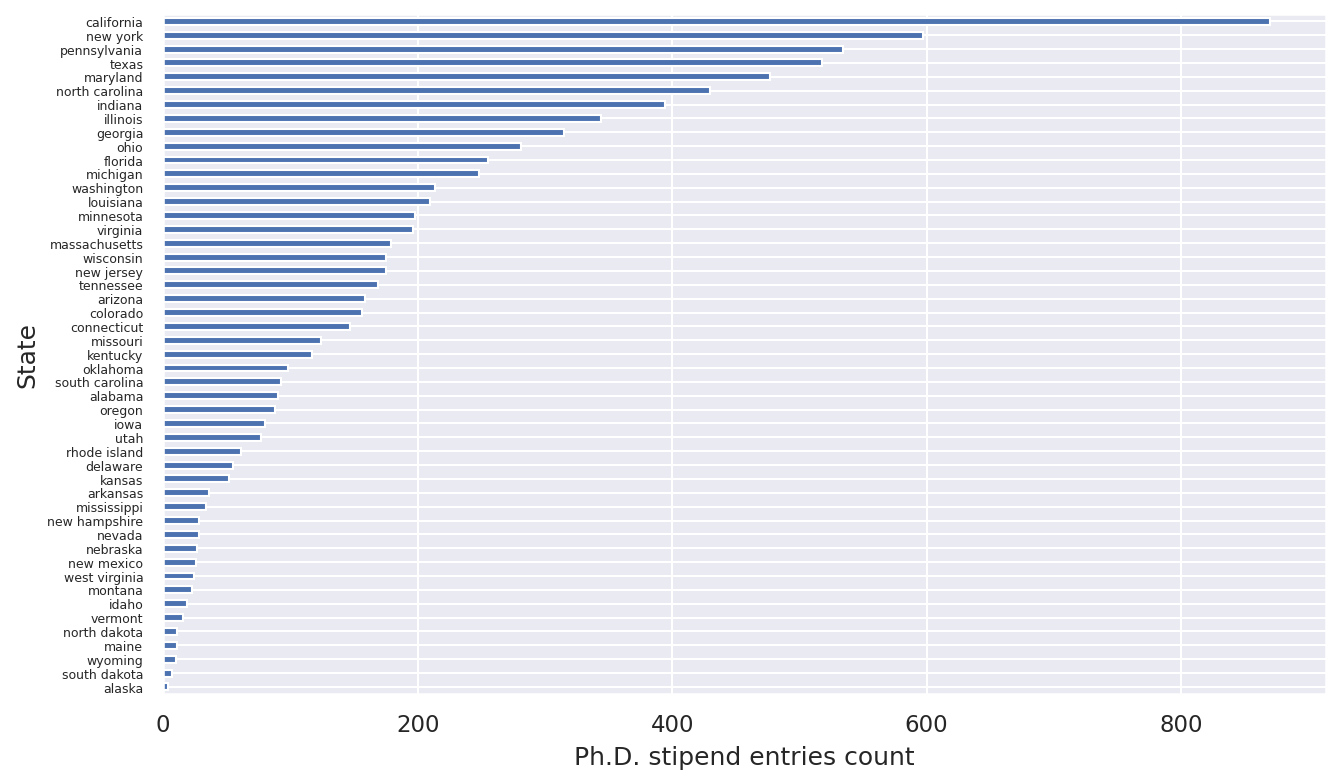

In [133]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 1, figsize = (10,6), dpi = 150)
count_on_state_values = df3["state_cleaned_column"].value_counts().sort_values(ascending =True)
count_on_state_values.plot(kind='barh')
plt.xlabel("Ph.D. stipend entries count")
plt.ylabel("State")
plt.yticks(fontsize = 6)
plt.show()


In [71]:
vector_non_us2 = df3[df3["state_cleaned_column"] == "puerto rico"].index
vector_non_us3 = df3[df3["state_cleaned_column"] == "hawaii"].index
df3.drop(vector_non_us2, inplace = True) 
df3.drop(vector_non_us3, inplace = True)

Let's drop Hawaii and Puerto Rico entries:

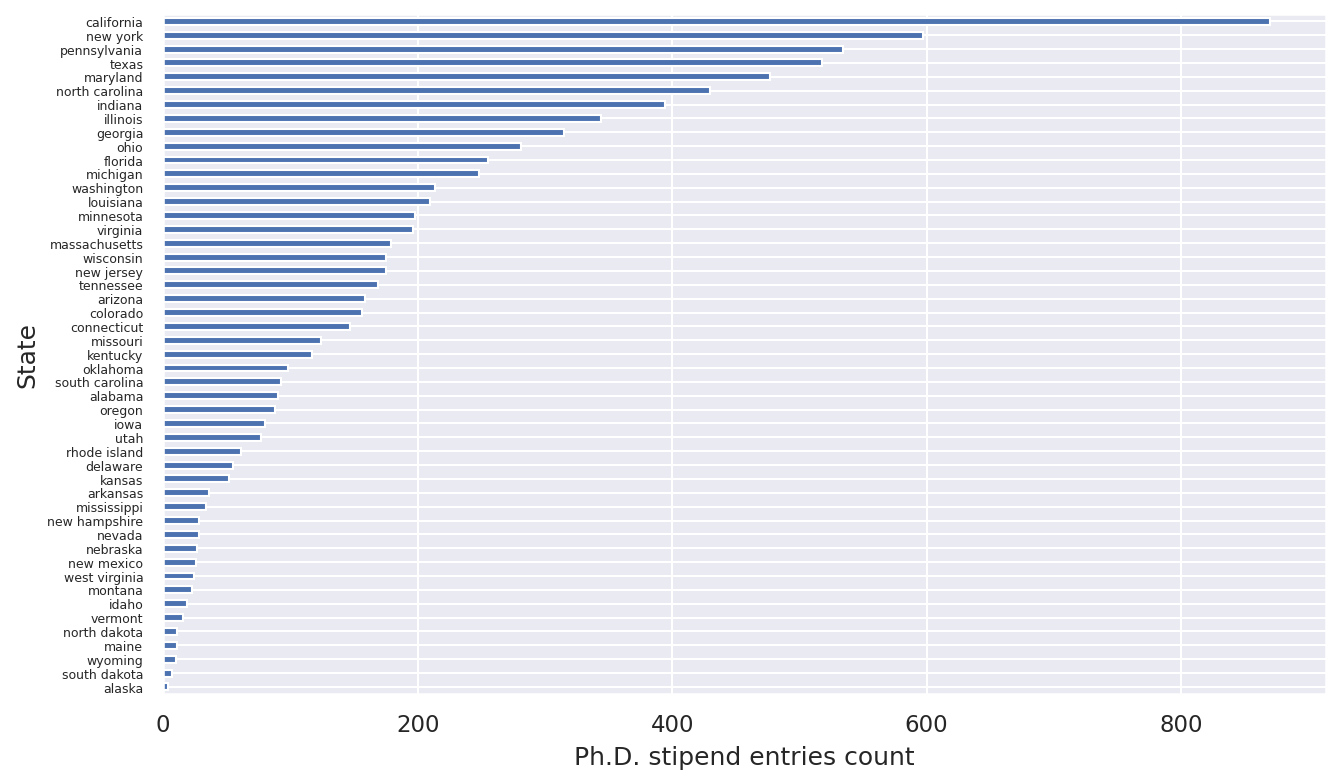

In [134]:
f, ax = plt.subplots(1, 1, figsize = (10,6), dpi = 150)
count_on_state_values_cleaned = df3["state_cleaned_column"].value_counts().sort_values(ascending =True)
count_on_state_values_cleaned.plot(kind='barh')
plt.xlabel("Ph.D. stipend entries count")
plt.ylabel("State")
plt.yticks(fontsize = 6)
plt.show()

The university column is now treated, and the states were sucessfully added. **The next step is to group the departments by field of knowledge.** We can use a similar procedure to reduce the number of unique entries, i.e. to strip the blank spaces and to lower case. We can also drop the old department, university and Fee columns.

In [73]:
def lower_and_strip(data):
  try:
    data = data.strip()
    data = data.lower()
  except:
    data = data
  return data

df3["department_pre_processing"] = df3["Department"].apply(lower_and_strip)
df3.drop(labels = ["Department","University", "Fees"], axis = 1, inplace = True)


Let's take a look on missing entries:

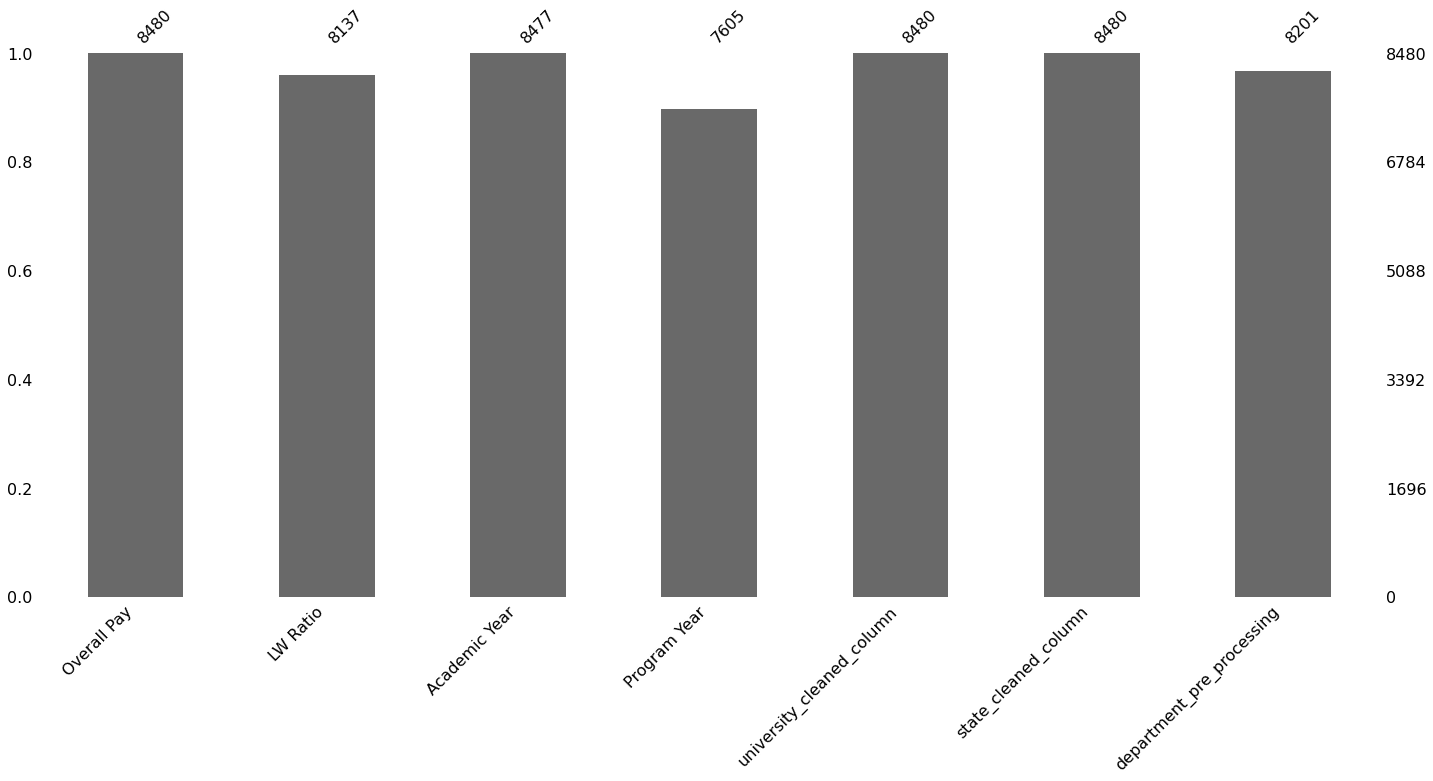

In [74]:
import missingno as msno 
plot = msno.bar(df3) 


Let's see how many department entries are linked to null. If they are few, we can drop them out. Ohterwise, we may think about a categorical imputation. 

In [75]:
null_department_entries_vector = list(df3["department_pre_processing"].isnull())
count = 0
for element in null_department_entries_vector:
  if element == True:
    count += 1
print("There are {} rows where the Department values is null. This is {}% of department data.".format(count, np.round(count/df3.shape[0],2)*100))


There are 279 rows where the Department values is null. This is 3.0% of department data.


At this point, the null university and overall pay rows were already droped out. Input the mode on null department entries can help keep the dataset size.
The most frequently reported department was **chemistry**, as we can see below:

In [76]:
import matplotlib.pyplot as plt
from scipy import stats
mode = stats.mode(df3["department_pre_processing"][:])
print("Considering all the department values, the most frequently reported department was {}".format(mode.mode[0]))
count_department_value = df3["department_pre_processing"].value_counts()
print(count_department_value)
df3["department_pre_processing"].value_counts().reset_index().to_csv('department_counts.csv')

Considering all the department values, the most frequently reported department was chemistry
chemistry                                         417
english                                           268
political science                                 265
psychology                                        262
sociology                                         250
                                                 ... 
mat sci                                             1
gvpt                                                1
marb                                                1
chemical engineering and materials science          1
plant pathology and environmental microbiology      1
Name: department_pre_processing, Length: 1943, dtype: int64


The function "fill" was created to fill the nan values with "chemistry":

In [77]:
def fill(data):
  if data is np.nan:
    data = 'chemistry'
  return data

df3["department_pre_processing_not_null"] = df3["department_pre_processing"].apply(fill)
df3.drop(labels = ["department_pre_processing"], axis = 1, inplace = True)
count_department_value = df3["department_pre_processing_not_null"].value_counts()
print(count_department_value)

chemistry                                         696
english                                           268
political science                                 265
psychology                                        262
sociology                                         250
                                                 ... 
mat sci                                             1
gvpt                                                1
marb                                                1
chemical engineering and materials science          1
plant pathology and environmental microbiology      1
Name: department_pre_processing_not_null, Length: 1943, dtype: int64


Let's use a word cloud to take a look at these unique entries:

There are 1943 unique values on department column.


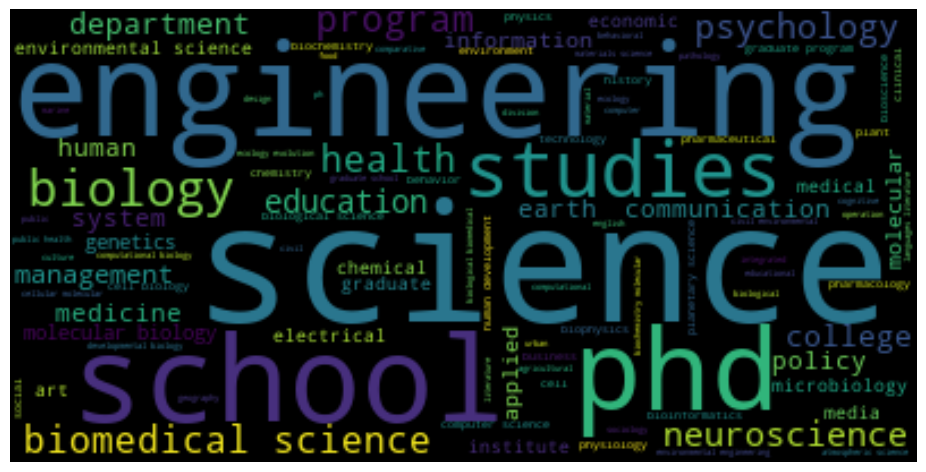

In [78]:
!pip install wordcloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
list_department_unique_initial_values = list(set(df3["department_pre_processing_not_null"]))
print("There are {} unique values on department column.".format(len(list_department_unique_initial_values)))
text = unique_string=(" ").join(list_department_unique_initial_values)
wordcloud = WordCloud().generate(text)
plt.figure(figsize = (60,6), dpi = 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The Engineering, Biology, Science, and Biomedical Science departmens present the most number of different unique entries. We should try to reduce the number of similar entries. **There are some unnecessary words that could be avoided: ["phd","studies", "school", "department", "college","institute", "program", "graduate", "applied"]**. To clean the data, it is usefull to remove these general words, to strip blank spaces and to lower case.  Let's see how many unique entries we have and the new wordcloud:

After removing the unnecessary words, there are 1921 unique departments value.


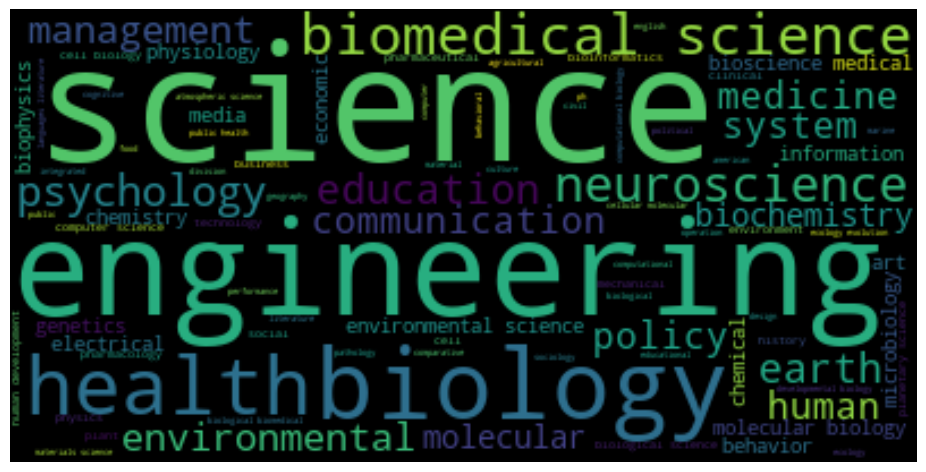

In [79]:

def clean_department(data):
  black_words_list = ["phd","studies", "school", "department", "college","institute", "program", "graduate", "applied"]
  for element_black in black_words_list:
    if element_black in data:
      data = data.replace(element_black, "")
    if data in ([" ",""]):
      data = "chemistry"  #blank space replaced by mode
  return data

df3["department_cleaned"] = df3["department_pre_processing_not_null"].apply(clean_department)
count_department_value = df3["department_cleaned"].value_counts()
df3["department_cleaned"].value_counts().reset_index().to_csv('department_cleaned_count.csv')
print("After removing the unnecessary words, there are {} unique departments value.".format(len(count_department_value)))
list_department_unique_cleaned_values = list(set(df3["department_cleaned"]))
text = unique_string=(" ").join(list_department_unique_cleaned_values)
wordcloud = WordCloud().generate(text)
plt.figure(figsize = (60,6), dpi = 100)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Now it's time to design a process to **group them by area of ​​knowledge**. The function field classifier searches for the knowledge field based on the hierarchy. **The algorithm asks the following questions to each deparment data entry:**

*   Does the department is in heatlh sciences field list?
        if true: classified as health science, if false: go to the following  questions 
*   Does the department is in science tech engineering math fiels list?
        if true: classsified as STEM , if false: go to the following  questions 
*   Does the department is in humanities list field?
        if true: classsified as humanities , if false: go to the following  questions
*   Does the department is in earth science and environment field list?
        if true: classsified as earth science , if false: go to the following  questions
*   Does the department is in public business and finance field list?
        if true: classified as public, business and finance, if false: go to the following  questions
*   Does the department name present "science"? 
        if true: classified as STEM, if false: go to the following  question
        this question is at the end of the function to avoid classifying "biomedical sciences", "geophysical sciences" and "social sciences" in the same category.
*   Does the department is still non-classified? 
        if true: classified as "non-classified", if false: it was already classified







    



In [81]:
def field_classifier(data):
  data.replace(" ", "")
  field = 0
  for element in list_health:
    if element in data:
      field = "health sciences"
  if field == 0:
    for element in list_stem:
      if element in data:
        field = "science, technology, engineering and math"
  if field == 0:
    for element in list_humanities:
      if element in data:
        field = "humanities"
  if field == 0:
    for element in list_earth:
      if element in data:
        field = "earth science and environment"
  if field == 0:
    for element in list_public_finance_business:
      if element in data:
        field = "public, finance and business"
  if field == 0:
    if "science" in data:
      field = "science, technology, engineering and math"
  if field == 0:
    field = "non-classified"
  return field 

list_stem = ["math", "engin", "physics", "comput","elect","statis","astro","material","mechanic","eecs","aerospac","mse","inform","robot","chem","aero","ee", "data","ecse","nano","machine","nsf","ece","mae","cse","cs","igsp","polymer","basic sciences","semte","space","operations","molecular","autom","industr","technol","eng","spatial","artificial intelligence","energy","planetary"]
list_health = ["bio","medic","health","nursing","bme","psych","pharma","kinesiol","md","bbs","bcmb","nutriti","dbbs","pathology","pibbs","genetic","neuro", "immuno", "gerontol", "epidemio", "cmb","cosp","mcdb","phamaco","mstp","gsph","bims","imp", "food","mcb", "physiolo","tetrad","bmb","gpibs","ils","gsbs","driskill","dgp","bstp","bmmb","aps","pmcb","nuin","ibms","oncolo","ngp","upgg","gbs","life","rehabilitation","dscb","genome","neural","anatomy","mbidp","bms","watson","clinic","sport","therapy","bmi","toxic","cell","brain","pathog"]
list_earth = ["ecology","geo","plant","natural","eeb","agro","agri","forestry","earth", "entomol", "efb","oeas","ocean", "environ","e&es","animal","seas","atmospheric","marine","botany","water","sustainability","ecosystem","crop science","soil","zoo","forest"]
list_humanities = ["literat","english","folklore","french","religi","music","arts","history","classic","teology","spanish","human","education","isntruction","communic","architect","cognitive","american","german","hearing","romance","afric","behavio","fpe", "philosophy", "sociolo","urban", "family", "child", "lingui","langua", "anthropol", "culture", "ead", "social", "philosphy", "theolog", "journal","gender","media", "pulse", "slavic","instruction","hispanic","scandinavian","east","csd","italian","learning","film","theater","international","cultur","medieval","ethnic","student","igp","sociol","rhetoric","design","archaeology","dance","teacher","counseling","theatre","art","arabic","divinity","occupational","bible","antropology","letters","portuguese","performance","russian","egyptology"]
list_public_finance_business = ["financ","business","account","government","polytic","policy","marketing", "public","politic","econom", "law", "regional", "management", "booth","justice","ibs","criminology","demography","risk","strategy","community","ices","sensory","philanthropic","enterpr","city","forens"]

df3["field"] = df3["department_cleaned"].apply(field_classifier)
df3.sample(10)


,Overall Pay,LW Ratio,Academic Year,Program Year,university_cleaned_column,state_cleaned_column,department_pre_processing_not_null,department_cleaned,field
6800,"$15,000",0.66,2016-2017,1st,university of wisconsin–madison,wisconsin,counseling psychology,counseling psychology,health sciences
1283,"$13,500",NaN,2019-2020,2nd,ohio university,ohio,higher education,higher education,humanities
6565,"$20,050",0.76,2017-2018,1st,"university of california, santa barbara",california,earth science,earth science,humanities
5052,"$26,000",1.16,2017-2018,1st,pennsylvania state university system,pennsylvania,mathematics,mathematics,"science, technology, engineering and math"
2941,"$-3,029",-0.13,2014-2015,NaN,"university of california, san diego",california,ohs,ohs,non-classified
3371,"$16,628",0.83,2018-2019,NaN,ohio state university,ohio,philosophy,philosophy,humanities
1441,"$40,000",NaN,2019-2020,3rd,cornell tech,new york,computer science,computer science,"science, technology, engineering and math"
5187,"$30,272",1.31,2017-2018,4th,university of michigan–dearborn,michigan,cell and developmental biology,cell and developmental biology,health sciences
3750,"$24,000",0.99,2018-2019,1st,university of connecticut,connecticut,psychology,psychology,health sciences
7722,"$28,000",1.18,2016-2017,1st,university of miami,florida,pibs,pibs,"public, finance and business"


Most departments' fields of knowledge were well classified. Let's see the entries that were classified as "other". This step could be improved in the future, by searching the non-classified departments on the internet and adding them to the correct field list. 

In [82]:
print("Non-classified departments:")
vector_other = df3.loc[df3["field"] == "non-classified"]
other_departments = vector_other["department_cleaned"]
count_other_departments = other_departments.value_counts().to_csv('other_department_counts.csv')
print(other_departments.value_counts())

Non-classified departments:
grad       3
nelc       2
camb       2
ist        2
ninds      2
          ..
cdse       1
cgph       1
sloan      1
chinese    1
gsb        1
Name: department_cleaned, Length: 163, dtype: int64


Let's see the dataset distribution by field of knowledge:

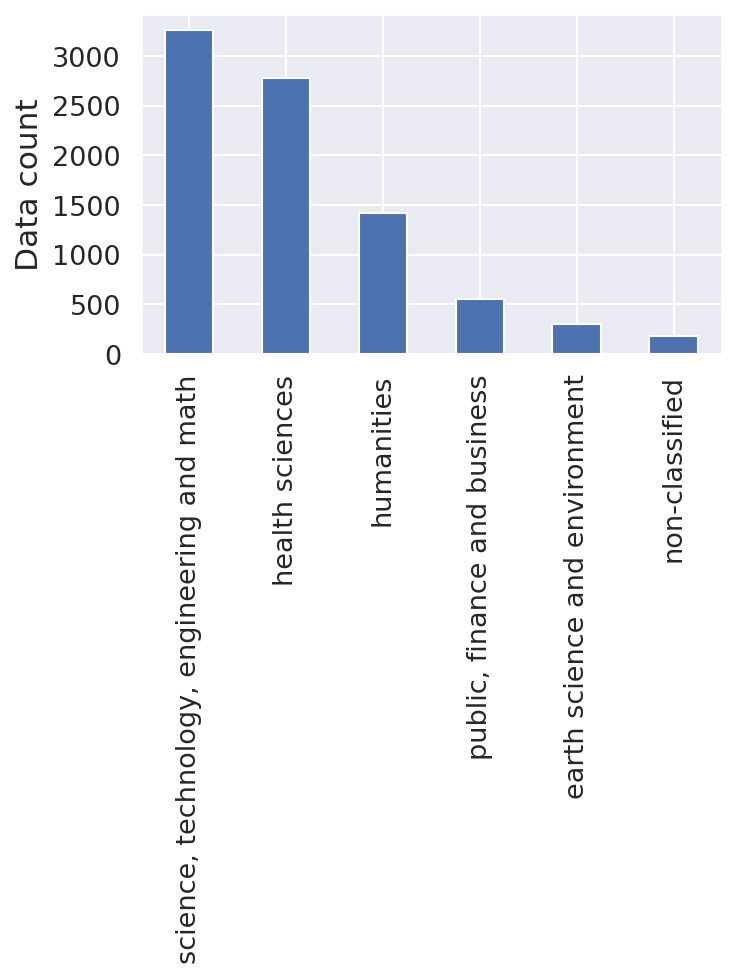

In [137]:
f, ax = plt.subplots(1, 1, figsize = (5,3), dpi = 150)
try:
  df3.drop(labels = ["department_cleaned"], axis = 1, inplace = True)
except:
  pass
df3['field'].value_counts().plot(kind='bar')
plt.ylabel("Data count", fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.show()

We can see that the most frequently reported fields were STEM and health sciences. Now that the department column was treated, **the next step is to treat the LW and program year columns**. It is important to count the percentage of missing data on these columns.

In [84]:
print("LW column: {} missing values, {} %".format(df3.shape[0]-8164, np.round(((df3.shape[0]-8164)/df3.shape[0])*100,2)))
print("Program year column: {} missing values, {} %".format(df3.shape[0]-7633, np.round(((df3.shape[0]-7633)/df3.shape[0])*100,2)))

LW column: 316 missing values, 3.73 %
Program year column: 847 missing values, 9.99 %


It's necessary to input the LW and Program Year missing values. We could try to associate a missing Program Year Value to information from other rows with the same university and department values. 

To investigate this possibility,  it is necessary to check if all the universities and departments have more than one count frequency on the dataset. 


The following line of code shows that there are some universities with only one entry. The program year imputation via similarity is not possible. Therefore, an alternative is doing this imputation based on the Program Year mode value.


In [85]:
print("Below we see that some university entries present only one occurrence:")
print(df3["university_cleaned_column"].value_counts())

Below we see that some university entries present only one occurrence:
duke university                                      179
university of north carolina at chapel hill          150
university of california, berkeley                   148
university of michigan–dearborn                      145
university of wisconsin–madison                      144
                                                    ... 
texas a&m college station                              1
university of dayton                                   1
university of nebraska omaha                           1
purdue university                                      1
southern california university of health sciences      1
Name: university_cleaned_column, Length: 391, dtype: int64


After performing the imputation with Program Year mode value, we can check that there are no longer missing values on this column: 

The Program Year mode imputation value is 1st


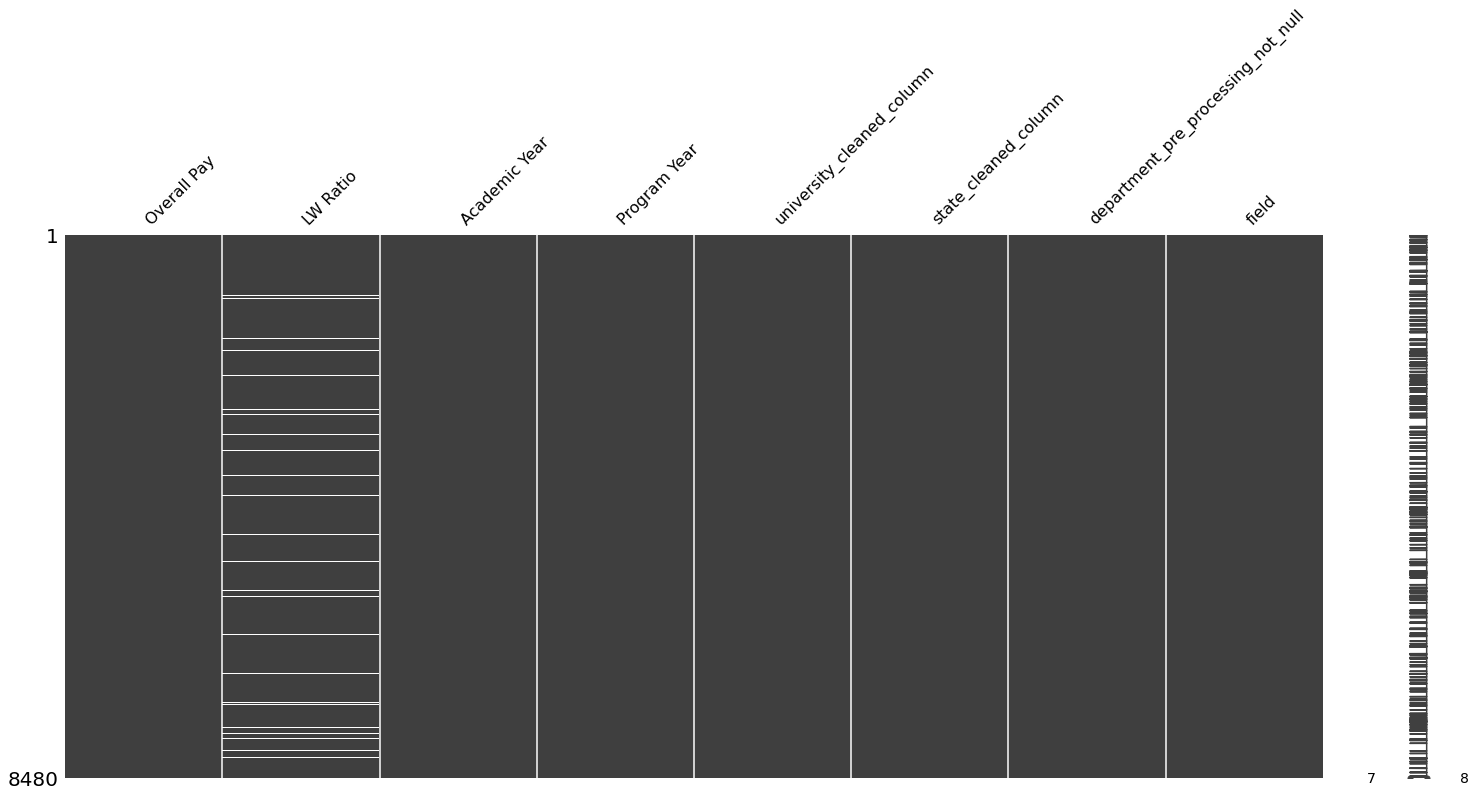

In [86]:
import statistics
program_year_imputation_value = statistics.mode(df3["Program Year"])
print('The Program Year mode imputation value is {}'.format(program_year_imputation_value))
df3.fillna({'Program Year':program_year_imputation_value}, inplace=True)
msno.matrix(df3)

Now we see that the only column with missing values is the LW ratio column.
This information is simply the Overall Pay value divided by the cost of living. 

As we don't have information on the cost of living granularity (level of detail) on the considered region, we could suppose that it should not vary too much for the same state and university entries. 

Even if any university possesses campuses located in different cities, but in the same state, the mode of cost of living is a good estimative.

Therefore, we could construct a new column called "Cost of living" created by multiplying the overall Pay column by the Lw ratio, if it exists.

But before doing that, **it's necessary to treat the Overall Pay Column**: 

I should convert the string type to int type on overall payment column. It is better to remove comma as thousand delimiter.
The string pattern seems to be:

The first charachter is '$'.

if **comma appears** on string, the payment is above 1K dollars:

    -Then the thousand left part is composed by some digits
    -Comma appears
    -The thousand right part is composed by 3 digits
if **comma does not appear** on string, the payment is below 1K dollars:

    -Then the digits can be converted into int type


To promote a sucessful conversion into integer, first we should see if the only non-numerical characters are "$" and "," . 



In [87]:
def search_non_numerical(data,list_of_other_non_digits,list_of_other_non_digits_data):
  list_of_expected_non_digits = ["$","-"]
  for element in data:
    if element.isdigit() == False and element not in list_of_expected_non_digits:
      list_of_other_non_digits.append(element)
      list_of_other_non_digits_data.append(data)
  return list_of_other_non_digits,list_of_other_non_digits_data

In [88]:
list_of_other_non_digits = []
list_of_other_non_digits_data = []
for data in df3["Overall Pay"]:
  (list_of_other_non_digits,list_of_other_non_digits_data) = search_non_numerical(data, list_of_other_non_digits, list_of_other_non_digits_data)
print("Non expected characters list = ")
print(set(list_of_other_non_digits))
print("Negative values found:")
print(set(list_of_other_non_digits_data))
print("{} negative Payment entries were found".format(len(list_of_other_non_digits_data)))

Non expected characters list = 
{','}
Negative values found:
{'$20,518', '$25,360', '$28,192', '$34,583', '$26,480', '$35,563', '$28,780', '$20,266', '$15,608', '$31,429', '$-31,790', '$27,510', '$33,712', '$24,996', '$6,344', '$17,603', '$33,379', '$12,605', '$32,004', '$22,369', '$31,385', '$18,564', '$31,800', '$15,030', '$25,750', '$29,923', '$29,200', '$1,581', '$28,900', '$24,480', '$36,601', '$37,240', '$35,676', '$18,029', '$27,343', '$31,602', '$40,560', '$27,200', '$28,350', '$25,354', '$27,530', '$16,800', '$14,528', '$29,666', '$40,400', '$19,872', '$27,011', '$22,484', '$43,890', '$17,785', '$3,600', '$19,400', '$95,000', '$30,539', '$17,875', '$34,200', '$27,666', '$16,084', '$15,675', '$12,350', '$23,098', '$27,534', '$39,842', '$19,631', '$1,000', '$230,000', '$26,027', '$35,250', '$20,050', '$16,500', '$24,880', '$27,024', '$30,720', '$28,125', '$21,974', '$20,829', '$18,971', '$2,730', '$23,404', '$29,025', '$9,220', '$33,676', '$20,915', '$23,970', '$35,792', '$10,39

As we can see, there is also a minus sign after dollar sign in 82 overall pay entries. May this be due to some mistyping? There are some unexpected values, as -100,000 (100,000 dollars is too high to a PhD overall stipend per year) and -276 ( 276 dollars is too low to a PhD overall stipend per year). I prefer to deal with these extreme values after performing a boxplot to check the outliers. At this moment, I will just convert these negative values into positive values.

**The algorithm to convert the STR values into INT values could be like this:**

* **if '-' appears** on string:

    delimiter set to '\$-' 

    split the string using '\$-' delimiter. 
    Get the remaining part of string

    with the remaining part, **if there is no comma**:
    
      convert into int value

  with the remaining part, **if there is a comma**:
      
      split using comma delimiter

      get the left part of comma

      get the right part of comma
      
      join both parts into string
      
      convert the final string into int

* **if '-' does not appear** on string:

    delimiter set to '\$'

    split the string using '\$' delimiter, and follow the previous process looking for comma.

As the process that looks for comma is invoked in both conditions, it is better to construct a function that gets the string after breaking data according to the right delimiter and perform the conversion depending on comma existence:


In [89]:
def str_to_int_depending_on_comma(input_str):
  if ',' in input_str:
    left_part = input_str.split(',')[0]
    right_part = input_str.split(',')[1]
    final_str = left_part + right_part
    output_int = int(final_str)
  else:
    output_int = int(input_str)
  return output_int
  

In [90]:
def search_delimiter(data):
  if '-' in data:
    delimiter = '$-'
    input_str = data.split(delimiter)[1]
    output = str_to_int_depending_on_comma(input_str)
  else:
    delimiter = '$'
    input_str = data.split(delimiter)[1]
    output = str_to_int_depending_on_comma(input_str)
  return output

In [91]:
df3["Overall Pay integer"] = df3["Overall Pay"].apply(search_delimiter)

print( "After converting string overall pay values into integer, the minimum value is {}, and the maximum value is {}.".format(min(df3["Overall Pay integer"]), max(df3["Overall Pay integer"])))

After converting string overall pay values into integer, the minimum value is 1, and the maximum value is 994000.


The overall pay values are non-negative and successfully converted into integers. But the minimum and maximum values are distant from reality. The boxplot can resume this information and can reveal the outliers. Outliers can seriously impact the average values, but the median value is less impacted. Therefore, the median value is the preferred metric.

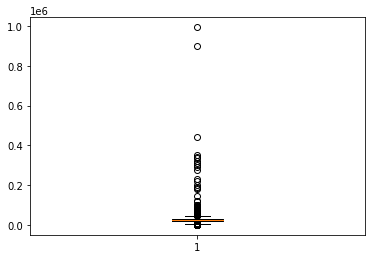

In [92]:
import matplotlib.pyplot as plt
plt.boxplot(df3["Overall Pay integer"])
plt.show()

The range of values ​​is so wide that the boxplot is flattened to cover all outliers ... There is a scale problem here. What about changing the scale to better see the interquartile? We can also print the information of median, mean, interquartile range, and the minimum and maximum values of the distribution.

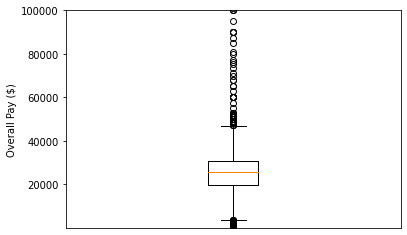

Median Overall Pay value: $25470, Mean : $25792, interquartile range: from $19810 to $30727, minimum= $3500, maximum= $47000, there are 365 outliers.


In [93]:
bp = plt.boxplot(df3["Overall Pay integer"])
plt.xlim(0.5,1.5)
plt.ylim(1e0,1e5)
plt.ylabel("Overall Pay ($)")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()
mean = int(np.mean(df3["Overall Pay integer"]))
median = int((bp['medians'][0].get_ydata()[0]))
min_interquartile = int((np.min(bp['boxes'][0].get_ydata())))
max_interquartile = int((np.max(bp['boxes'][0].get_ydata())))
max_cap =int(np.min(bp['caps'][1].get_ydata()))
min_cap = int(np.min(bp['caps'][0].get_ydata()))
outliers_quantity =len(bp['fliers'][0].get_ydata())
print("Median Overall Pay value: ${}, Mean : ${}, interquartile range: from ${} to ${}, minimum= ${}, maximum= ${}, there are {} outliers.".format(median,mean, min_interquartile, max_interquartile, min_cap,max_cap, outliers_quantity))

One way to deal with outliers is to consider that all the outliers above the maximum value (Q3+1.5 IQ) are supposed to be equal to the 95 percentile value. And all the outliers below the minimum value are supposed to be equal to the 5 percentile value.

In [94]:
def treat_outlier(data, min_cap, max_cap):
  if data > max_cap:
    data = max_cap
  if data < min_cap:
    data = min_cap
  return data

In [95]:
df3["Overall Pay Integer without outliers"]= df3.apply(lambda x:  treat_outlier(x["Overall Pay integer"], min_cap, max_cap), axis=1)
#print(max(df3["Overall Pay Integer without outliers"]))

Now that the outliers were treated, it's time to make a better plot comparing PhD stipend to the USA median income. The mean, median, and other values were called "treated", referring to the outliers removal process. The U.S. Census Bureau lists the annual median personal income at $35,977 in 2019. 

reference: https://fred.stlouisfed.org/series/MEPAINUSA672N

In [98]:
median_income_us = 35977
#get statistical data from boxplot
bp2 = plt.boxplot(df3["Overall Pay Integer without outliers"])
plt.xlim(0.5,1.5)
plt.ylim(1e0,1e5)
plt.ylabel("Overall Pay ($)")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
mean_treated = int(np.mean(df3["Overall Pay Integer without outliers"]))
median_treated = int((bp2['medians'][0].get_ydata()[0]))
min_interquartile_treated = int((np.min(bp2['boxes'][0].get_ydata())))
max_interquartile_treated = int((np.max(bp2['boxes'][0].get_ydata())))
max_cap_treated =int(np.min(bp2['caps'][1].get_ydata()))
min_cap_treated = int(np.min(bp2['caps'][0].get_ydata()))
plt.close()

Median = $25470, IQ = $19810  to   $30727


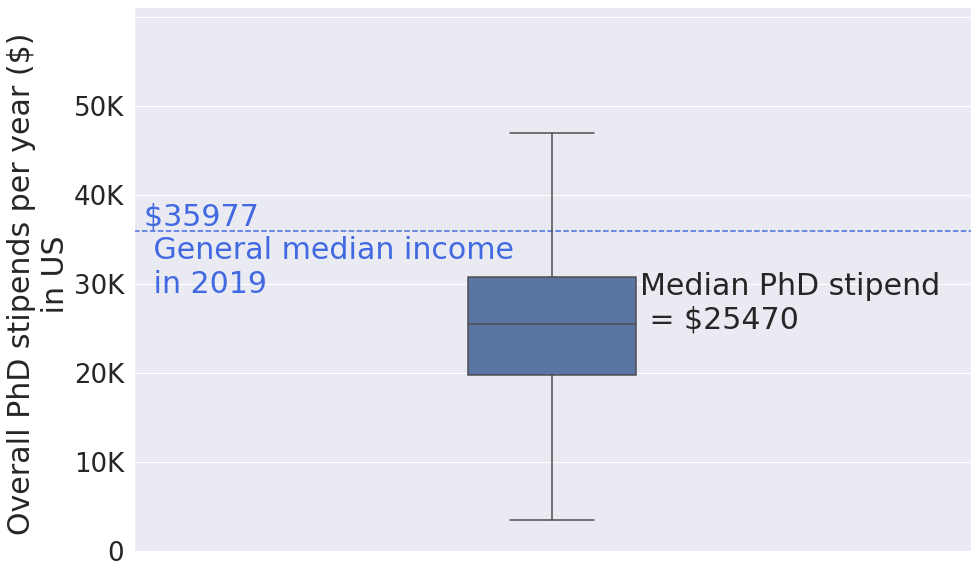

In [138]:
my_string = "Median = ${}, IQ = ${}  to   ${}".format(median_treated, min_interquartile_treated, max_interquartile_treated)
print(my_string)

#better plot with with seaborn 

import seaborn as sns
f, ax = plt.subplots(1, 1, figsize = (15, 10))
sns.set_theme(style="darkgrid")
ax = sns.boxplot(y=df3["Overall Pay Integer without outliers"])
plt.xlim(-2,2)
plt.ylim(0,1.3*max_cap_treated)
plt.yticks(fontsize = 26)
plt.ylabel("Overall PhD stipends per year ($) \n in US", fontsize = 30)
my_string2 = "Median PhD stipend \n = \${}".format(median_treated)
median_income_str = "\${} \n General median income \n in 2019".format(median_income_us)
ax.set_yticklabels(["0", "10K", "20K", "30K", "40K", "50K"])
ax.text(-1.95, 29000,median_income_str, fontsize=30, color = 'royalblue')
ax.text(0.42, 25000,my_string2, fontsize=30)
ax.hlines(35977,xmin = -2, xmax = 2, color = 'royalblue',linestyle= '--')
plt.show()

In [100]:
median_income_us = 35977
ratio_percent = np.round((median_treated/median_income_us)*100,1)
print("The median PhD stipend was {}% of US median income in 2019.".format(ratio_percent))

The median PhD stipend was 70.8% of US median income in 2019.


Now that the Overall Pay distribution was shown, the question 1 was answered,let's move on. 

*   ~How is the PhD students salary distributed? (Median, variability, outliers)~
*   Is there a relation between the mean salary and the University?
*   Is there a relation between the mean salary and the Department?
*   Is there a relation between the mean salary and the Program year? What can also be posed as: does the program tradition play a role on PhD salaries?

We can move on by constructing the "Cost of living" column, using the function create_cost_of_living_column, that simply divides the Overall Pay by LW Ration for non null LW entries 

In [101]:
def create_cost_of_living_column(overall_pay, living_wage_ratio):
  try:
    cost_living = overall_pay / living_wage_ratio
  except:
    cost_living = 0 
  return cost_living


In [102]:
df3["Cost of living"] = df3.apply(lambda x: create_cost_of_living_column(x["Overall Pay Integer without outliers"], x["LW Ratio"]), axis=1)
df3.sample(10)

,Overall Pay,LW Ratio,Academic Year,Program Year,university_cleaned_column,state_cleaned_column,department_pre_processing_not_null,field,Overall Pay integer,Overall Pay Integer without outliers,Cost of living
4794,"$32,593",1.62,2018-2019,3rd,ohio state university,ohio,chemistry,"science, technology, engineering and math",32593,32593,20119.135802
9103,"$24,000",1.22,2014-2015,1st,university of michigan–dearborn,michigan,mechanical engineering,"science, technology, engineering and math",24000,24000,19672.131148
8198,"$39,400",1.97,2016-2017,1st,university of arkansas - fayetteville,arkansas,business administration - management,"public, finance and business",39400,39400,20000.000000
5106,"$25,992",1.13,2017-2018,1st,university of minnesota twin cities,minnesota,physics,"science, technology, engineering and math",25992,25992,23001.769912
2146,"$34,000",1.41,2019-2020,5th,cheyney university of pennsylvania,pennsylvania,biomedical graduate studies/biochemistry and m...,health sciences,34000,34000,24113.475177
729,"$28,975",1.11,2020-2021,1st,university of vermont,vermont,neuroscience,health sciences,28975,28975,26103.603604
3202,"$25,000",1.14,2019-2020,1st,university of illinois at urbana–champaign,illinois,linguistics,"science, technology, engineering and math",25000,25000,21929.824561
8497,"$21,970",0.94,2015-2016,3rd,emory university,georgia,chemistry,"science, technology, engineering and math",21970,21970,23372.340426
6685,"$28,500",1.38,2017-2018,1st,university of pittsburgh,pennsylvania,immunology,health sciences,28500,28500,20652.173913
7866,"$291,000",11.99,2016-2017,1st,northwestern state university,louisiana,political science,"public, finance and business",291000,47000,3919.933278


Let's check if there is any NaN  for Cost of Living:

In [103]:
null_cost_living = cost_of_living_grouped_state["Cost of living"].isna()
print(cost_of_living_grouped_state[:][null_cost_living])


Empty DataFrame
Columns: [Cost of living]
Index: []


As there is no NaN value, we are ready to obtain the perform the statistical analysis on this column. We can regroup the dataframe and take a look at the median cost of living for each state. 

{'south dakota': 18881.98757763975, 'north dakota': 19205.95238095238, 'nebraska': 19506.172839506173, 'idaho': 19580.41958041958, 'ohio': 19983.078991596638, 'arkansas': 20000.0, 'oklahoma': 20155.35443139135, 'kentucky': 20424.033563080615, 'kansas': 20481.927710843374, 'missouri': 20629.37062937063, 'wyoming': 20782.52032520325, 'new mexico': 20814.064856711913, 'south carolina': 20930.232558139534, 'oregon': 20991.869918699187, 'montana': 21004.201680672268, 'nevada': 21080.26874115983, 'iowa': 21311.475409836065, 'alabama': 21366.459627329197, 'maine': 21473.19587628866, 'indiana': 21551.724137931036, 'mississippi': 21633.033033033033, 'texas': 21818.181818181816, 'arizona': 22118.98734177215, 'north carolina': 22222.222222222223, 'utah': 22222.222222222223, 'west virginia': 22307.69230769231, 'colorado': 22522.522522522522, 'pennsylvania': 22540.983606557376, 'rhode island': 22744.897959183672, 'wisconsin': 22807.017543859653, 'minnesota': 22839.386584289496, 'virginia': 22857.14

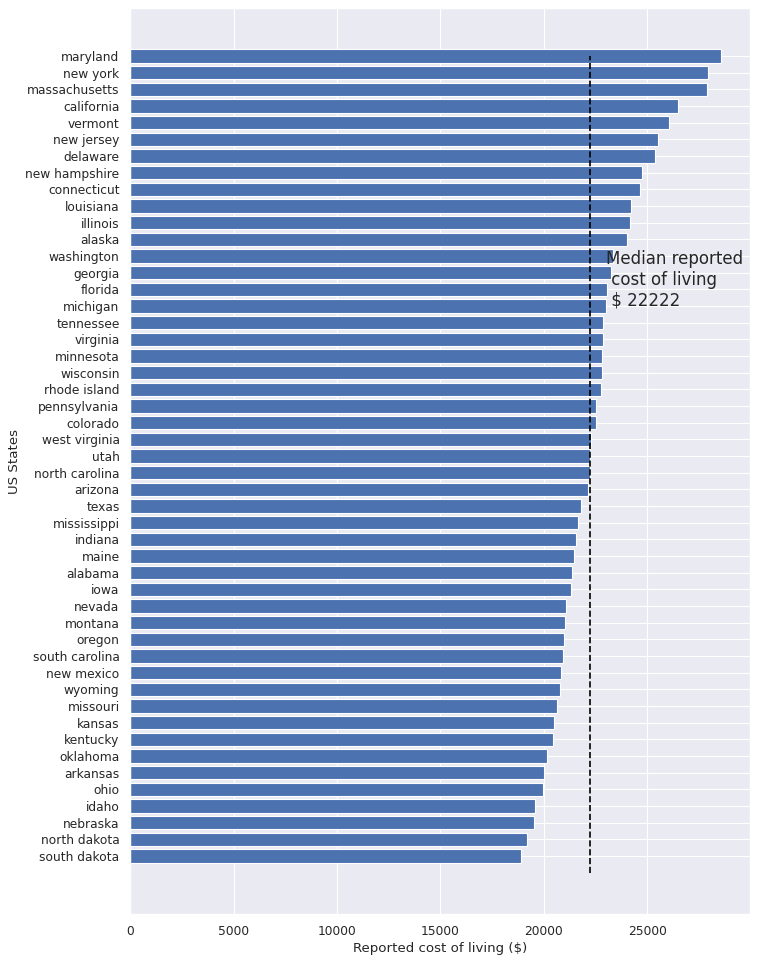

In [132]:
cost_of_living_grouped_state = df3.groupby(df3['state_cleaned_column'])[['Cost of living']].median()
pd.set_option('display.max_rows', 100)
list_states_lw_group = list(cost_of_living_grouped_state.index)
list_cost_living_lw_group = list(cost_of_living_grouped_state['Cost of living'])
dict_keys_on_state = dict(zip(list_states_lw_group,list_cost_living_lw_group))
#sort dictionary on cost of living:
dict_keys_on_state_sorted = dict(sorted(dict_keys_on_state.items(), key=lambda item: item[1]))
f, ax = plt.subplots(1, 1, figsize = (10, 15), dpi = 80)
plt.barh(list(dict_keys_on_state_sorted.keys()), width = list(dict_keys_on_state_sorted.values()))
plt.xlabel("Reported cost of living ($)")
plt.ylabel("US States")
ax.vlines(np.median(list_cost_living_lw_group), ymin = -1, ymax = 48,color = "black",linestyle= '--')
string_median_cost_of_living = "Median reported \n cost of living \n \$ {} ".format(round(np.median(list_cost_living_lw_group)))
ax.text(23000, 33,string_median_cost_of_living, fontsize=15)
plt.show()